# Tutorial: Beyond Linear Programming, (CPLEX Part2)

This notebook describes some special cases of LP, as well as some other non-LP techniques, and also under which conditions they should be used. 

Before continuing, you should ensure that you followed the CPLEX Tutorial Part 1.

After completing this unit, you should be able to describe what a network model is, and the benefits of using network models, explain the concepts of nonlinearity and convexity, describe what a piecewise linear function is, and describe the differences between Linear Programming (LP), Integer Programming (IP), Mixed-Integer Programming (MIP),  and Quadratic Programming (QP).  You should also be able to construct a simple MIP model. 

>This notebook is part of **[Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)**
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Cloud Pak for Data as a Service](https://www.ibm.com/products/cloud-pak-for-data/as-a-service/) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using `IBM Cloud Pak for Data as a Service` right away).
>
> CPLEX is available on <i>IBM Cloud Pack for Data</i> and <i>IBM Cloud Pak for Data as a Service</i>:
>    - <i>IBM Cloud Pak for Data as a Service</i>: Depends on the runtime used:
>         - <i>Python 3.x</i> runtime: Community edition
>         - <i>Python 3.x + DO</i> runtime: full edition
>    - <i>Cloud Pack for Data</i>: Community edition is installed by default. Please install the `DO` addon in `Watson Studio Premium` for the full edition



Table of contents:

* [CPLEX Modeling for Python](#Use-IBM-Decision-Optimization-CPLEX-Modeling-for-Python)
* [Network models](#Network-models)
* [Non-linearity and Convexity](#Non-linearity-and-Convexity)
* [Integer Optimization](#Integer-Optimization)
* [Quadratic Programming](#Quadratic-Programming)

We will use DOcplex to write small samples to illustrate the topics

## Use IBM Decision Optimization CPLEX Modeling for Python

Let's use the [DOcplex](http://ibmdecisionoptimization.github.io/docplex-doc/) Python library to write sample models in Python.

### Download the library

Install `CPLEX` (Community Edition) and `docplex` if they are not installed.

In `IBM Cloud Pak for Data as a Service` notebooks, `CPLEX` and `docplex` are preinstalled.

In [1]:
import sys
try:
    import cplex
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install cplex
    else:
        !pip install --user cplex

Installs `DOcplex`if needed

In [2]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
    else:
        !pip install --user docplex

If either `CPLEX` or `docplex` where installed in the steps above, you will need to restart your jupyter kernel for the changes to be taken into account.

# Network models

In this topic, you’ll learn what a network model is, and how its structure can be exploited for more efficient solutions.

## Networks in real life

Several problems encountered in Operations Research (OR) involve networks, such as:
Distribution problems (for example, transportation networks)
Assignment problems (for example, networks of workers and jobs they could be assigned to)
Planning problems (for example, critical path analysis for project planning)

Many network models are special LP problems for which specialized solution algorithms exist. 

It is important to know whether a problem can be formulated as a network model to exploit the special structure.

This topic introduces networks in general, as well as some well-known instances of network models.

## Network modeling concepts

Any network structure can be described using two types of objects:

- Nodes: Defined points in the network, for example warehouses.
- Arcs: An arc connects two nodes, for example a road connecting two warehouses. 

An arc can be _directed_, which means than an arc $a_{ij}$ from node $i$ to node $j$ is different from arc $a_ji$ that begins at node $j$ and ends at node $i$.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_5.png?raw=true" >
</ul> 

 A sequence of arcs connecting two nodes is called a chain. Each arc in a chain shares exactly one node with the preceding arc.

 When all the arcs in a chain are directed such that it is possible to traverse the chain in the directions of the arcs from the start node to the end node, it is called a path.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_6.png?raw=true" >
</ul> 

## Different types of network problems

The following are some well-known types of network problems:
- Transportation problem
- Transshipment problem
- Assignment problem
- Shortest path problem
- Critical path analysis

Next, you'll learn how to recognize each of these, and how their special structure can be exploited.

### The Transportation Problem

One of the most common real-world network problems is the transportation problem.  This type of problem involves a set of supply nodes and a set of demand nodes.  The objective is to minimize the transportation cost from the supply nodes to the demand nodes, so as to satisfy the demand, and without exceeding the suppliers’ capacities.  

Such a problem can be depicted in a graph, with supply nodes, demand nodes, and connecting arcs.  The supply capacity is indicated with the supply nodes, while the demand is indicated with the demand nodes, and the transportation costs are indicated on the arcs.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_8.png?raw=true" >
</ul> 

The LP formulation involves one type of variable, namely x(i,j) representing the quantity transported from supply node i to demand node j.  The objective is to minimize the total transportation cost across all arcs.  The constraints are flow conservation constraints.  The first two constraints state that the outflow from each supply node should be less than or equal to the supply capacity.  The next three constraints state that the inflow into each demand node should equal the demand at that node.   The domain for the shipments on the allowable arcs is set to be greater than or equal to zero, while the shipment quantities on the disallowed arcs are set to zero.  

Even though arcs (1,4) and (2,3) do not exist in the graph, the variables are included in the slide to show the special structure of the transportation problem.  If you were to formulate such a model in practice, you’d simply exclude these variables. 

#### Formulating a simple transportation problem with DOcplex

In the next section, we formulate the problem described above using DOcplex.

#### What data for the transpotation problem?

Input ndoes are integers ranging in {1, 2}; output nodes are integers ranging from 3 to 5.

The data consists in three Python dictionaries:

- one dictionary gives capacity values for all input nodes
- one dictionary contains demands for all target nodes
- one last dictionary holds cost values for some (source, target) pair of nodes.

In [3]:
capacities = {1: 15, 2: 20}
demands = {3: 7, 4: 10, 5: 15}
costs = {(1,3): 2, (1,5):4, (2,4):5, (2,5):3}

# Python ranges will be used to iterate on source, target nodes.
source = range(1, 3) # {1, 2}
target = range(3, 6) # {3,4,5}

#### Create a model instance

In [4]:
from docplex.mp.model import Model

tm = Model(name='transportation')

#### Define the decision variables
- The continuous variable `desk` represents the production of desk telephones.
- The continuous variable `cell` represents the production of cell phones.

In [5]:
# create flow variables for each couple of nodes
# x(i,j) is the flow going out of node i to node j
x = {(i,j): tm.continuous_var(name='x_{0}_{1}'.format(i,j)) for i in source for j in target}

# each arc comes with a cost. Minimize all costed flows
tm.minimize(tm.sum(x[i,j]*costs.get((i,j), 0) for i in source for j in target))

tm.print_information()

Model: transportation
 - number of variables: 6
   - binary=0, integer=0, continuous=6
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize
 - problem type is: LP


#### Set up the constraints

- For each source node, the total outbound flow must be smaller than available quantity.
- For each target node, total inbound flow must be greater thand demand

In [6]:
# for each node, total outgoing flow must be smaller than available quantity
for i in source:
    tm.add_constraint(tm.sum(x[i,j] for j in target) <= capacities[i])
    
# for each target node, total ingoing flow must be greater thand demand
for j in target:
    tm.add_constraint(tm.sum(x[i,j] for i in source) >= demands[j])

#### Express the business objective: minimize total flow cost

Each arc has a unit cost and we want to minimize the total cost. If an arc has no entry in the dictionary, we assume a zero cost (using the `dict.get` method.

In [7]:
tm.minimize(tm.sum(x[i,j]*costs.get((i,j), 0)))

### Solve the model

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

In any case, `Model.solve()` returns a solution object in Python, containing the optimal values of decision variables, if the solve succeeds, or else it returns `None`.

In [8]:
tms = tm.solve()
assert tms
tms.display()

solution for: transportation
objective: 0.000
x_1_5 = 15.000
x_2_3 = 10.000
x_2_4 = 10.000


### Special structure of  network problem

The special structure of the transportation problem, as well as many other types of network problems, allows the use of specialized algorithms that lead to significant reductions in solution time.

Another important characteristic of transportation problems (and also some other network problems) is that if all the capacities and demands are integer, then the decision variables will take integer values.

This is important to know, because it means that you do not have to use integer variables in such cases. 

As you'll learn in a later topic, integer variables often lead to problems that require much more computational effort compared to problems with only continuous variables.


## The Transshipment Problem

The transshipment problem is similar to the transportation problem, except that intermediate nodes exist in addition to the supply and demand nodes.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_10.png?raw=true" >
</ul> 


In this example, nodes 3 and 4 are intermediate nodes.  

The LP formulation is also similar, in the sense that it involves an objective to minimize the transportation cost across all arcs, and a set of flow conservation constraints.  The first two constraints are for the supply nodes, and state that the outflow from each supply node should equal the capacity of that node, plus any inflow into that same node.  The next two constraints are for the intermediate nodes, and state that the inflow into an intermediate node should equal the outflow out of that node.  The last two constraints are for the demand nodes, and state that the inflow into each demand node should equal the demand at that node.  The domain for the variables is to be greater than or equal to zero. 

It is possible to write the transshipment problem as a transportation problem in order to use specialized algorithms that exploit the structure of transportation problem. This conversion is not covered as part of this course because CPLEX Optimizer does this conversion automatically, but you can find details in the textbooks listed at the end of this course


## The Assignment Problem

The Assignment Problem is the problem of assigning one set of items to another, while optimizing a given objective.  For example, the problem of assigning workers to jobs so as to minimize the hiring costs.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_11.png?raw=true" >
</ul> 

In this example, the workers are represented by nodes 1 through 3, while the jobs are represented with nodes A, B and C.  The cost of assigning a worker to a job is shown on each arc.  The objective is to minimize the total assignment cost.  Again, the constraints can be seen as flow conservation constraints.  The first three constraints state that each job is filled by exactly one person, while the last three constraints state that each person is assigned to exactly one job.  The variables should now take a value of 1 if worker i is assigned to job j, and zero otherwise.  

This problem is a special case of the transportation problem, with each supply node capacity set to one, and each demand set to 1.  What’s also important to know is that even though the variables must take 0-1 values, they can be declared as continuous variables due to the integrality property, namely that if all capacity and demand quantities are integer, the variables will take integer values.

## The Shortest Path Problem

The Shortest Path Problem is the problem of finding the shortest path through a network.  For example, to find the minimum travel time between two cities in a network of cities.  The shortest path problem is a special case of the transshipment problem, where there is exactly one supply node and one demand node, and the supply and demand are both equal to 1.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_12.png?raw=true" >
</ul> 

In this example, each node represents a city, and each arc represents the road connecting two cities.  The travel time is indicated on each arc.  The variable x(i, j) takes a value of 1 if the arc between i and j is included in the shortest path, and zero otherwise.  The objective is to minimize the total travel time.  As with the other network problems, the constraints can be seen as flow conservation constraints.  A constraint exists for each node (or each city) and the constraints state that exactly one arc should be chosen into each city, and exactly one arc should be chosen out of each city.  

Again, even though the x variables must take 0-1 values, they can be declared as continuous due to the integrality property (that is, all the capacity and demand quantities are integer). 


## Critical Path Analysis

Critical path analysis is a technique used in project planning to find the set of critical activities where a delay in one of the critical activities will lead to an overall project delay.  The critical path is the longest path in the network.  It represents the minimum completion time of the project, and if any task on the critical path is delayed, the entire project will be delayed.  

Tasks that do not lie on the critical path may be delayed to some extent without impacting the final completion date of the project.  The critical path will change if a non-critical task is delayed to a point where it becomes critical. 

For example, consider a kitchen remodeling project where the home owners are remodeling their kitchen with the eventual goal of hosting a party.  Some of the tasks can be done simultaneously, such as plumbing and electricity, while others can only be started once a previous task is complete, for example the sink can only be installed once the plumbing is complete.  The critical path will indicate the minimum time for completing this project, so that they know when they can have their party.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_13.png?raw=true" >
</ul> 

Here, the arcs show the task durations, while the nodes show the task start times.  For modeling purposes, let t(i) be the start time of the tasks originating at node i.  The objective is to minimize the project completion time, namely t7.  The constraints indicate the task duration and precedence.  For example, the third constraint indicates that the minimum time between starting the sink installation (that is, node 3), and starting the plumbing (that is, node 1) is 3 days.  Arcs 3-2 and 4-2 are dummy tasks required to complete the model.  Such dummy tasks have no minimum time associated with them, but are used to model precedence involving more than one preceding tasks of varying duration, in this case that the plumbing, electricity, and appliance order time must be complete before appliances can be installed. 

In this graph, it’s easy to see that the critical path lies on nodes 0 – 2 – 6 – 7, with a total length of 19 days.  Therefore, any delay in the appliance ordering or installation will delay the party date.  

Large projects can lead to very complex networks, and specialized algorithms exist for critical path analysis.


## CPLEX Network Optimizer

As you’ve now seen, many network problems are special types of LP problems. In many cases, using the Simplex or Dual-simplex Optimizers is the most efficient way to solve them. In some cases, specialized algorithms can solve such problems more efficiently. 

CPLEX automatically invokes the Network Optimizer  when it's likely that it would improve solution time compared to the other algorithms. 

It is also possible to force the use (or not) of the Network Optimizer by setting the `lpopt` parameter of
a DOcplex model to 3 (remember 1 was primal simplex, 2 was dual simplex, and 4 is for barrier). 

# Non-linearity and Convexity

In this topic, you’ll learn about the concepts of nonlinearity and convexity, and their significance in relation to mathematical programming.

## Non-linearity

In many problems, the relationships between decision variables are not linear. Examples of industries where nonlinear optimization problems are often encountered are:
The chemical process industry, for example oil refining or pipeline design
The finance sector, for example stock portfolio optimization

- Nonlinear Programming (NLP) is often used to solve such optimization problems. One of the NLP techniques available through DOcplex is Quadratic Programming (QP), used especially for portfolio optimization. 

- Sometimes it is possible to approximate a nonlinear function with a set of linear functions and then solve the problem using LP techniques. The success of this depends on whether the nonlinear function is convex or nonconvex. 

## Convexity

A region of the space is _convex_ if any point lying on a straight line between any two points in the region is also in the region.

All LPs are convex, because an LP involves the minimization of a linear function over a feasible region defined by a set of linear functions, and linear functions are convex.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_19.png?raw=true" >
</ul> 

## Approximating a non-linear program with piecewise-linear functions

A convex nonlinear function can be approximated by a set of linear functions, as shown in the next figure. This could be used to allow solution with LP techniques.  

Such an approximate function consisting of several linear line segments is called a _piecewise linear_ function. 

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_21.png?raw=true" >
</ul> 

We will start by discussing this approximation.

Piecewise linear programming is used when dealing with functions consisting of several linear segments. Examples of where this might be appropriate are piecewise linear approximations of convex nonlinear functions, and piecewise linear functions representing economies of scale (for example a unit cost that changes when a certain number of units are ordered.) 

## An example of piecewise linear programming: economies of scale


Consider a transportation problem in which the transportation cost between an origin,$i$, and a destination, $j$, depends on the size of the shipment, $ship_{ij}$:
- The first 1000 items have a shipping cost of \$0.40 per item
- For the next 2000 items (i.e. items 1001-3000) the cost is \$ 0.20 per item
- From item 3001 on, the cost decreases to \$ 0.10 per item.

The cost of each quantity bracket remains intact (that is, the cost per unit changes only for additional units, and remains unchanged for the previous quantity bracket). 

Within each bracket there is a linear relationship between cost and quantity, but at each breakpoint the rate of linear variation changes. 

If you graph this function, you see that at each breakpoint, the slope of the line changes. The section of the graph between two breakpoints is a linear piece.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_25.png?raw=true" >
</ul> 

The diagram shows that the total shipping cost is evaluated by 3 different linear functions, each determined by the quantity shipped $Q$:

- 0.40 * items when $Q \le 1000$,
- 0.40 * 1000 + 0.20 * (Q - 1000) when $1000 <= Q = 3000$,
- 0.40 * 1000 + 0.20 * 2000 + 0.10 * (Q - 3000) when $Q \ge 3000$.

This is an example of a piecewise linear function. Note that this function is _continuous_, that is has no 'jump' in its values, but this not mandatory for piecewise linear functions.

### Piecewise linear functions with DOcplex

DOcplex lets you define piecewise linear functions in two styles: either with a set of points, or with a set of values and slopes. As the problem is formulated with slopes, we'll start with this formulation.

The `Model.piecewise_with_slopes` method takes a sequence of $(x_{i}, slope_{i})$ values where $slope_{i}$ is the slope of the function between $x_{i-1}$ and $x_{i}$.

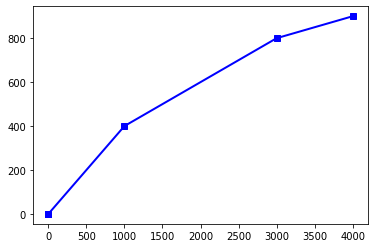

In [9]:
# Display matplotlib plots in the notebook
%matplotlib inline

# create a new model to attach piecewise
pm = Model(name='pwl')
pwf1 = pm.piecewise_as_slopes([(0, 0), (0.4, 1000), (0.2, 3000)], lastslope=0.1)
# plot the function
pwf1.plot(lx=-1, rx=4000, k=1, color='b', marker='s', linewidth=2)

#### Defining a piecewise linear functions from break points

DOcplex also allows to define a piecewise linear function from the set of its _break_ points, that is a sequence of $(x_{i}, y_{i})$ values, plus the final slope towards $+\infty$. Here the sequence of breakpoints is:

- (0,0)
- (1000, 400): computed with 0.4 marginal cost
- (3000, 800): computed as 400 + 0.2 * (3000 - 1000)
- final slope is 0.1

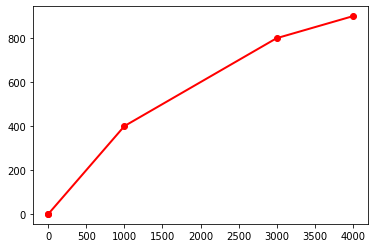

In [10]:
pwf2 = pm.piecewise(preslope=0, breaksxy=[(0, 0), (1000, 400), (3000, 800)], postslope=0.1)
# plot the function
pwf2.plot(lx=-1, rx=4000, k=1, color='r', marker='o', linewidth=2)

To bind a variable $y$ to the result of applying the peicewise linear function to another variable $x$, you just have to add the following constraint to the model:

In [11]:
x = pm.continuous_var(name='x')
y = pm.continuous_var(name='y')
pm.add_constraint(y == pwf2(x));  # y is constrained to be equal to f(x)

# Integer Optimization

In this topic, you’ll learn how to deal with integer decision variables by using Integer Programming and Mixed-Integer Programming, and how these techniques differ from LP.

## Problems requiring integers

For some optimization problems the decision variables should take integer values. 

- One example is problems involving the production of large indivisible items, such as airplanes or cars.  It usually does not make sense to use a continuous variable to represent the number of airplanes to produce, because there is no point in manufacturing a partial airplane, and each finished airplane involves a large cost.  

- Another example of where one would use integer variables is to model a particular state, such as on or off. For example, a unit commitment problem where integer variables are used to represent the state of a particular unit being either on or off.  

- Planning of investments also requires integer variables, for example a variable that takes a value of 1 to invest in a warehouse, and 0 to ignore it.  

Finally, integer variables are often used to model logic between different decision, for example that a given tax break is only applicable if a certain investment is made.

## Different types of integer decisions

Many types of decisions can be modeled by using integer variables. 

One example is yes/no decisions, with a value of 1 for yes, and 0 for no. For example, if x equals 1, new manufacturing equipment should be installed, and if x equals 0, it should not. 

Integer variables are also used to model state or mode decisions. For example, if z1 equals 1 the machine operates in mode 1, if z2 equals 1, the machine operates in mode 2, and if z3 equals 1 the machine operates in mode 3.  The same integer is often used to express both yes/no decisions and logic. For example, y1 equals 1 could in this case also be used to indicate that machine 1 is installed, and 0 otherwise. 

Finally, integer variables are used tomodel cases where a value can take only integer values: for example: how many flights should a company operate between two airports.

## Types of integer variables

In general, integer variables can take any integer value, such as 0, 1, 2, 3, and so forth.  Integers that should only take the values of 1 or 0 are known as binary (or Boolean) variables. Binary variables are also often referred to as Boolean variables because the Boolean values of true and false are analogous to 1 and 0. 

To ensure that an integer variable can only take the values 0 and 1, one can give it an upper bound of 1 or declare it to be of type binary. In a DOcplex  model, decision variables are assumed to be nonnegative unless otherwise specified and the lower bound of 0 does not need to be declared explicitly. 

### Declaring integer decision variables in DOcplex

DOcplex has specific methods to create integer and binary variables.

In [12]:
im = Model(name='integer_programming')
b = im.binary_var(name='boolean_var')
ijk = im.integer_var(name='int_var')
im.print_information()

Model: integer_programming
 - number of variables: 2
   - binary=1, integer=1, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


## Modeling techniques with integer and binary variables

Integer and binary variables are very useful to express logical constraints. Here are a few examples of
such constraints.

### Indicator variables

Indicator variables are binary variables used to indicate whether a certain set of conditions is valid (with the variable equal to 1) or not (with the variable equal to 0). For example, consider a production problem where you want to distinguish between two states, namely production above a minimum threshold, and no production. 

To model this, define a binary variable $y$ to take a value of 1 if the production is above the minimum threshold (called minProd), and 0 if there is no production. Assume $production$ is a continuous variable containing the produced quantity. 
This leads to these two constraints.

$$
production \ge minProd * y\\
production \le maxProd * y
$$

Here, maxProd is an upper bound on the production quantity. Thus, if y = 1, the minimum and maximum production bounds hold, and if y = 0, the production is set to zero. 


### Logical constraints - an example

For example, consider an investment decision involving a production plant and two warehouses. 

- If the production plant is invested in, then either warehouse 1 or warehouse 2 may be invested in (not both).

- If the production plant is not invested in, then neither of the two warehouses may be invested in.

Let $yPlant$ be 1 if you decide to invest in the production plant, and 0 otherwise. 
Similar for $yWarehouse1$ and $yWarehouse2$.
Then this example can be modeled as follows:

$$
yWarehouse1 + yWarehouse2 <= yPlant
$$

If $yPlant$ is 0 then both $yWarehouse1$ and $yWarehouse2$ are set to zero. 

On the opposite, if one warehouse variable is set to 1, then $yPlant$ is also set to 1. Finally, this constraint also states that warehouse variables cannot be both equal to 1.


## IP versus MIP

When all the decision variables in a linear model should take integer values, the model is an Integer Program (or **IP**). 

When some of the decision variables may also take continuous values, the model is a Mixed Integer Program (or **MIP**). 

MIPs are very common in, for example, some supply chain applications where investment decisions may be represented by integers and production quantities are represented by continuous variables.

IPs and MIPs are generally much more difficult to solve than LPs.

The solution complexity increases with the number of possible combinations of the integer variables, and such problems are often referred to as being “combinatorial”.

In the worst case, the solution complexity increases exponentially with the number of integer decision variables.

Many advanced algorithms can solve complex IPs and MIPs in reasonable time


### An integer programming example

In the telephone production problem where the optimal solution found in chapter 2 'Linear programming' had integer values, it is possible that the solution becomes non-integer under certain circumstances, for example:

- Change the availability of the assembly machine to 401 hours
- Change the painting machine availability to 492 hours
- Change the profit for a desk phone to 12.4
- Change the profit for a cell phone to 20.2

The fractional values for profit are quite realistic. Even though the fractional times for availability are not entirely realistic, these are used here to illustrate how fractional solutions may occur. 

Let's solve again the telephone production problem with these new data. A detailed explanation of the model is found in notebook 2: 'Linear Programming'

In [13]:
lm = Model(name='lp_telephone_production')
desk = lm.continuous_var(name='desk')
cell = lm.continuous_var(name='cell')
# write constraints
# constraint #1: desk production is greater than 100
lm.add_constraint(desk >= 100)

# constraint #2: cell production is greater than 100
lm.add_constraint(cell >= 100)

# constraint #3: assembly time limit
ct_assembly = lm.add_constraint( 0.2 * desk + 0.4 * cell <= 401)

# constraint #4: painting time limit
ct_painting = lm.add_constraint( 0.5 * desk + 0.4 * cell <= 492)
lm.maximize(12.4 * desk + 20.2 * cell)

ls = lm.solve()
lm.print_solution()

objective: 20948.167
  desk=303.333
  cell=850.833


As we can see the optimal solution contains fractional values for number of telephones, which are not realistic.
To ensure we get integer values in the solution, we can use integer decision variables.

Let's solve a new model, identical except that its two decision variables are declared as _integer_ variables.

In [14]:
im = Model(name='ip_telephone_production')
desk = im.integer_var(name='desk')
cell = im.integer_var(name='cell')
# write constraints
# constraint #1: desk production is greater than 100
im.add_constraint(desk >= 100)

# constraint #2: cell production is greater than 100
im.add_constraint(cell >= 100)

# constraint #3: assembly time limit
im.add_constraint( 0.2 * desk + 0.4 * cell <= 401)

# constraint #4: painting time limit
im.add_constraint( 0.5 * desk + 0.4 * cell <= 492)
im.maximize(12.4 * desk + 20.2 * cell)

si = im.solve()
im.print_solution()

objective: 20947.400
  desk=303
  cell=851


As expected, the IP model returns integer values as optimal solution.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_39.png?raw=true" >
</ul> 

This graphic shows the new feasible region where the dots indicate the feasible solutions.  That is, solutions where the variables take only integer values.  This graphic is not according to scale, because it’s not possible to indicate all the integer points graphically for this example. What you should take away from this graphic, is that the feasible region is now a collection of points, as opposed to a solid area.  Because, in this example, the integer solution does not lie on an extreme point of the continuous feasible region, LP techniques would not find the integer optimum.  To find the integer optimum, you should use an integer programming technique. 


### Rouding a fractional solution

An idea that often comes up to deal with fractional solutions is to solve an LP and then round the fractional numbers in order to find an integer solution. However, because the optimal solution is always on the edge of the feasible region, rounding can lead to an infeasible solution, that is, a solution that lies outside the feasible region. In the case of the telephone problem, rounding would produce infeasible results for both types of phones. 

When large quantities of items are produced, for example thousands of phones, rounding may be still be a good approach to avoid integer variables.
In general, you should use an integer programming algorithm to solve IPs.  The most well-known of these is the branch-and-bound algorithm. 


## The branch and bound method

The _branch and bound_ method, implemented in CPLEX Mixed-Integer Optimizer, provides an efficient way to solve IP and MIP problems. This method begins by relaxing the integer requirement and treating the problem as an LP. If all the variables take integer values, the solution is complete. If not, the algorithm begins a tree search.  You’ll now see an example of this tree search. 

Consider this integer programming problem, involving an objective to maximize, three constraints, and three non-negative integer variables (this is the default for DOcplex variables).

$
maximize\ x + y + 2 z\\
subject\ to: 7x + 2y + 3z <= 36\\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 5x + 4y + 7z <= 42\\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 2x + 3y + 5z <= 28\\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x,y,z \ge 0
$

### Branch and Bound: the root node

The first node of the branch and bound tree is the LP relaxation of the original IP model.  
LP relaxation means that the integer variables have been relaxed to be continuous variables.  
The solution to the LP relaxation of a maximization IP, such as this, provides an upper bound to the original problem, in this case that bound is eleven and five elevenths.  
The current lower bound is minus infinity. 

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_43.png?raw=true" >
</ul> 

In this case, the solution is fractional and the tree search continues in order to try and find an integer solution.

### Branch and Bound: branching on a variable

The algorithm next chooses one of the variables to branch on, in this case $x$, and adds two constraints to create two subproblems.  
These two constraints are based on the relaxed value of x, namely one and three elevenths.  In the one subproblem, $x$ is required to be less than or equal to one, and in the other problem, $x$ is required to be greater than or equal to two, in order to eliminate the fractional solution found.  
IP2 gives another fractional solution, but IP3 gives an integer solution.  This integer solution of 10 is the new lower bound to the original maximization problem, because it is the best current solution to the maximization problem.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_44.png?raw=true" >
</ul> 

The algorithm will terminate when the gap between the upper and lower bounds is sufficiently small, but at this point there is still more of the tree to explore.

### Branch and Bound: iteration

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_45.png?raw=true" >
</ul> 

Two new subproblems are now generated from IP2, and these constraints are determined by the fractional value of z in IP2.  In IP4, z must be less than or equal to 5, and in IP3 z must be greater than or equal to 6. IP4 gives another fractional solution, while IP3 is infeasible and can be pruned.  When a node is pruned, the node is not explored further in the tree.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_46.png?raw=true" >
</ul> 

Next, two more subproblems are created from IP4, namely one with y less than or equal to zero in IP6, and one with y greater than or equal to 1 in IP5.  IP6 yields an integer solution of 11, which is an improvement of the previously found lower bound of 10. IP5 gives a fractional solution and can be explored further.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_47.png?raw=true" >
</ul> 

So another two subproblems are created from IP5, namely IP8 with z less than or equal to 4, and IP7 with z greater than or equal to 5.  However, the constraint added for IP4 specifies that z must be less than or equal to 5, so node IP7 immediately yields an integer solution with an objective value of 11, which is the same objective as for IP6.  IP8 yields an integer solution with objective value of 9, which is a worse solution than those previously found and IP8 can therefore be discarded.  

The optimal solution reported is the integer solution with the best objective value that was found first, namely the solution to IP6.

The progess of the Branch & Bound algorithm can be monitored by looking at the CPLEX the _log_. Adding the keyword argument `log_output=True` to the `Model.solve()` method will print the log on the standard output.
You can see the best bound going down until the gap closes and the final solution of 11 is returned.
By default the CPLEX log is not printed.

In [15]:
bbm = Model(name='b&b')
x, y, z = bbm.integer_var_list(3, name=['x', 'y', 'z'])
bbm.maximize(x + y + 2*z)
bbm.add_constraint(7*x + 2*y + 3*z <= 36)
bbm.add_constraint(5*x + 4*y + 7*z <= 42)
bbm.add_constraint(2*x + 3*y + 5*z <= 28)
bbm.solve(log_output=True);

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 3 columns, and 9 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 3 rows, 3 columns, and 9 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       24.0000              --- 
      0     0       11.4286     2        0.0000      

## Modeling yes/no decisions with binary variables: an example

Binary variables are often used to model yes/no decisions.  
Consider again the telephone production problem, but ignore the lower bounds of 100 on production for simplicity. The company is considering replacing the assembly machine with a newer machine that requires less time for cell phones, namely 18 minutes per phone, but more time for desk phones, namely 15 minutes per phone. This machine is available for 430 hours, as opposed to the 400 hours of the existing assembly machine, because it requires less downtime. 

We will design and write a model that uses binary variables to help the company choose between the two machines. 

The steps to formulate the mixed-integer model are:
- Add four new variables (desk1, desk2, cell1, and cell2, to indicate the production on assembly machines 1 and 2, respectively.
- Add two constraints to define the total production of desk and cell to equal the sum of production from the two assembly machines.
- Rewrite the constraint for assembly machine 1 to use the new variables for that machine (desk1 and cell1).
- Add a similar constraint for the production on assembly machine 2.
- Define a Boolean variable, y, to take a value of 1 if assembly machine 1 is chosen, and 0 if assembly machine 2 is chosen.
- Use the z variable to set the production to zero for the machine that is not chosen.


### Implementing the yes/no decision model with DOcplex

First, create a model instance.

In [16]:
tm2 = Model('decision_phone')

#### Setup decision variables

we create two sets of (desk, cell) integer variables, one per machine type, plus the total production variables.
Note that the total production variables do not need to be declared if the four typed productions are integers.
As the sum of two integers, they will always be integers; the less we have of integer variables, the easier CPLEX willsolve the problem.

In addition, we define an extra binary variable $z$ to model the choice we are facing: use machine #1 or machine #2.

In [17]:
# variables for total production
desk = tm2.integer_var(name='desk', lb=100)
cell = tm2.continuous_var(name='cell', lb=100)

# two variables per machine type:
desk1 = tm2.integer_var(name='desk1')
cell1 = tm2.integer_var(name='cell1')

desk2 = tm2.integer_var(name='desk2')
cell2 = tm2.integer_var(name='cell2')

# yes no variable
z = tm2.binary_var(name='z')

#### Setup constraints

- The constraint for painting machine limit is identical to the basic telephone model
- Two extra constraints express the total production as the sum of productions on the two assembly machines.
- Each assembly machine type has its own constraint, in which variable $z$ expresses the exclusive choice between the two.

In [18]:

# total production is sum of type1 + type 2
tm2.add_constraint(desk == desk1 + desk2)
tm2.add_constraint(cell == cell1 + cell2)

# production on assembly machine of type 1 must be less than 400 if z is 1, else 0
tm2.add_constraint(0.2 * desk1 + 0.4 * cell1 <= 400 * z)
# production on assembly machine of type 2 must be less than 430 if z is 0, else 0
tm2.add_constraint(0.25 * desk2 + 0.3 * cell2 <= 430 * (1-z))

# painting machine limit is identical
# constraint #4: painting time limit
tm2.add_constraint( 0.5 * desk + 0.4 * cell <= 490)

tm2.print_information()

Model: decision_phone
 - number of variables: 7
   - binary=1, integer=5, continuous=1
 - number of constraints: 5
   - linear=5
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Expressing the objective

The objective is identical: maximize total profit, using total productions.

In [19]:
tm2.maximize(12 * desk + 20 * cell)

#### Solve with the Decision Optimization solve service

In [20]:
tm2s= tm2.solve(log_output=True)
assert tm2s
tm2.print_solution()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 12800.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve modified 2 coefficients.
Reduced MIP has 5 rows, 7 columns, and 14 nonzeros.
Reduced MIP has 1 binaries, 5 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.01 ticks)
Probing fixed 0 vars, tightened 1 bounds.
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve modified 1 coefficients.
Reduced MIP has 5 rows, 7 columns, and 14 nonzeros.
Reduced MIP has 1 binaries, 6 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.01 ticks)

        Nodes                                    

#### Conclusion

This model demonstrates that the optimal solution is to use machine #2 , producing 100 desk phones and 1100 cell phones.

### Using binary variables for logical decisions

What if the company had to choose between 3 possible candidates for the assembly machine, as opposed to two?

The above model can be generalized with three binary variables $z1$, $z2$, $z3$ each of which is equal to 1 only if machine type 1,2, or 3 is used. But then we need to express that _exactly_ one of those variables must be equal to 1. How can we achive this?

The answer is to add  the following constraint to the model:

$$
z_{1} + z_{2} + z_{3} = 1
$$

Thus, if one of zs variables is equal to 0, the two other areequal to zero (remember binary variables can take value 0 or 1).

# Quadratic Programming

In this topic, you’ll learn what a quadratic program (or QP) is, and learn how quadratic programming applies to portfolio management.

## Quadratic Functions

Mathematically, a function is quadratic if: 
- The variables are only first or second degree (that is, one variable may be multiplied by another variable, and any of the variables may be squared) and
- The coefficients of the variables are constant numeric values (that is, integers or real numbers). 

A quadratic function is also known as a second degree polynomial function. 

Geometrically, a quadratic function is a curve or curved surface. For example, a quadratic function in two dimensions is a curved line, such as a parabola, hyperbola, ellipse, or circle. 

## What is a Quadratic Program?


Quadratic Programs (or QPs) have quadratic objectives and linear constraints. A model that has quadratic functions in the constraints is a Quadratically Constrained Program (or QCP). The objective function of a QCP may be quadratic or linear.  
A simple formulation of a QP is:

$$
	{minimize}\ \frac{1}{2}{x^{t}Qx + c^{t}x}\\ 
subject\ to \\
\ \ 	Ax \ge b \\
\ \ 	lb \le x \le ub \\
$$

The first objective term is quadratic, with Q being the matrix of objective function coefficients of the quadratic terms.  The second term and the constraints are linear. CPLEX Optimizer can solve convex QP and QCP problems. Quadratic programming is used in several real-world situations, for example portfolio management or chemical process modeling. In the next two slides, you’ll see how QP applies to portfolio management. 

A model that has quadratic functions in the constraints is a Quadratically Constrained Program (QCP). The objective function of a QCP problem may be quadratic or linear. 

## Portfolio management

In order to mitigate risk while ensuring a reasonable level of return, investors purchase a variety of securities and combine these into an investment portfolio. Each security has an expected return and an associated level of risk (or variance). 

Securities sometimes covary, that is, they change together with some classes of securities, and in the opposite direction of other classes of securities. An example of positive covariance is when shares in technology companies follow similar patterns of increases and decreases in value. On the other hand, as the price of oil rises, shares in oil companies may increase in value, but plastics manufacturers, who depend on petroleum as a major primary resource, may see their shares decline in value as their costs go up and vice versa. This is negative covariance. 

To optimize a portfolio in terms of risk and return, an investor will evaluate the sum of expected returns of the securities, the total variances of the securities, and the covariances of the securities.  A portfolio that contains a large number of positively covariant securities is more risky (and potentially more rewarding) than one that contains a mix of positively and negatively covariant securities. 

### Potfolio optimization: what use?

Portfolio optimization is used to select securities to maximize the rate of return, while managing the volatility of the portfolio and remaining within the investment budget. 

As the securities covary with one another, selecting the right mix of securities can change or even reduce the volatility of the portfolio with the same expected return. 

At a given expected rate of return, there is one portfolio which has the lowest risk. If you plot each lowest-risk portfolio for each expected rate of return, the result is a convex graph, called the efficient frontier. 

The risk-return characteristics of a portfolio change in a nonlinear fashion, and quadratic expressions are used to model them.

Data comes in two parts:

- Basic data on shares: activity sector, expected return rate, and whether or not activity is based in North America
- The covariance square matrix for all pairs of shares.

The `pandas` Python data analysis library is used to store the data. Let's set up and declare the data.

In [21]:
import pandas as pd
from pandas import DataFrame

In [22]:
sec_data = {
    'sector': ['treasury', 'hardware', 'theater', 'telecom', 'brewery', 'highways', 'cars', 'bank', 'software',
               'electronics'],
    'return': [5, 17, 26, 12, 8, 9, 7, 6, 31, 21],
    'area': ['N-Am.', 'N-Am.', 'N-Am.', 'N-Am.', "ww", 'ww', 'ww', 'ww', 'ww', 'ww']
}

df_secs = DataFrame(sec_data, columns=['sector', 'return', 'area'])
df_secs.set_index(['sector'], inplace=True)

# store set of share names
securities = df_secs.index
df_secs

,return,area
sector,,
treasury,5,N-Am.
hardware,17,N-Am.
theater,26,N-Am.
telecom,12,N-Am.
brewery,8,ww
highways,9,ww
cars,7,ww
bank,6,ww
software,31,ww


### The covariance matrix

Covraiance matrix is a square matrix (its size is the nu,ber of shares). The covariance matrix is also stored in a pandas DataFrame.

In [23]:
# the variance matrix
var = {
    "treasury": [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "hardware": [0, 19, -2, 4, 1, 1, 1, 0.5, 10, 5],
    "theater": [0, -2, 28, 1, 2, 1, 1, 0, -2, -1],
    "telecom": [0, 4, 1, 22, 0, 1, 2, 0, 3, 4],
    "brewery": [0, 1, 2, 0, 4, -1.5, -2, -1, 1, 1],
    "highways": [0, 1, 1, 1, -1.5, 3.5, 2, 0.5, 1, 1.5],
    "cars": [0, 1, 1, 2, -2, 2, 5, 0.5, 1, 2.5],
    "bank": [0, 0.5, 0, 0, -1, 0.5, 0.5, 1, 0.5, 0.5],
    "software": [0, 10, -2, 3, 1, 1, 1, 0.5, 25, 8],
    "electronics": [0, 5, -1, 4, 1, 1.5, 2.5, 0.5, 8, 16]
}

dfv = pd.DataFrame(var, index=securities, columns=securities)
dfv

sector,treasury,hardware,theater,telecom,brewery,highways,cars,bank,software,electronics
sector,,,,,,,,,,
treasury,0.1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
hardware,0.0,19.0,-2,4,1.0,1.0,1.0,0.5,10.0,5.0
theater,0.0,-2.0,28,1,2.0,1.0,1.0,0.0,-2.0,-1.0
telecom,0.0,4.0,1,22,0.0,1.0,2.0,0.0,3.0,4.0
brewery,0.0,1.0,2,0,4.0,-1.5,-2.0,-1.0,1.0,1.0
highways,0.0,1.0,1,1,-1.5,3.5,2.0,0.5,1.0,1.5
cars,0.0,1.0,1,2,-2.0,2.0,5.0,0.5,1.0,2.5
bank,0.0,0.5,0,0,-1.0,0.5,0.5,1.0,0.5,0.5
software,0.0,10.0,-2,3,1.0,1.0,1.0,0.5,25.0,8.0


There is a constraint that the total fraction of wealth invested in North American securities must be greater than some minimum value. To implement this constraint, we add a new column to df_secs, that is equal to 1 if and only if the area column equals "N.-Am.", else is equal to 0 (see later how we use this column to implemen the constraint).

In [24]:
def is_nam(s):
    return 1 if s == 'N-Am.' else 0

df_secs['is_na'] = df_secs['area'].apply(is_nam)
df_secs

,return,area,is_na
sector,,,
treasury,5,N-Am.,1
hardware,17,N-Am.,1
theater,26,N-Am.,1
telecom,12,N-Am.,1
brewery,8,ww,0
highways,9,ww,0
cars,7,ww,0
bank,6,ww,0
software,31,ww,0


In [25]:
from docplex.mp.model import Model

mdl = Model(name='portfolio_miqp')

We model variables as the _fraction_ of wealth to invest in each share. Each variable is a continuous variable between 0 and 1. Variables are stored in a column of the dataframe.

In [26]:
# create variables
df_secs['frac'] = mdl.continuous_var_list(securities, name='frac', ub=1)

#### Express the business constraints

The business constraints are the following:

- the sum of allocated fractions equal 100%
- each security cannot exceed a certain percentage of the initial allocated wealth (here 30%)
- there must be at least 40% of wealth invested in securities hosted in North America
- compound return on investment must be less than or equal to a minimum target (say 9%)

In [27]:
# max fraction
frac_max = 0.3
for row in df_secs.itertuples():
    mdl.add_constraint(row.frac <= 0.3)
    
# sum of fractions equal 100%
mdl.add_constraint(mdl.sum(df_secs.frac) == 1);

# north america constraint:
#    - add a 1-0 column equal to 1 
# compute the scalar product of frac variables and the 1-0 'is_na' column and set a minimum
mdl.add_constraint(mdl.dot(df_secs.frac, df_secs.is_na) >= .4);

# ensure minimal return on investment
target_return = 9 # return data is expressed in percents
# again we use scalar product to compute compound return rate
# keep the expression to use as a kpi.
actual_return = mdl.dot(df_secs.frac, df_secs['return'])
mdl.add_kpi(actual_return, 'ROI')

# keep the constraint for later use (more on this later)
ct_return = mdl.add_constraint(actual_return >= 9);

#### Express the objective

The objective or goal is to minimize risk, here computed as the variance of the allocation, given a minimum return rate is guaranteed.
Variance is computed as a _quadratic_ expression, which makes this model a Quadratic Programming (QP) model

In [28]:
# KPIs
fracs = df_secs.frac
variance = mdl.sum(float(dfv[sec1][sec2]) * fracs[sec1] * fracs[sec2] for sec1 in securities for sec2 in securities)
mdl.add_kpi(variance, 'Variance')

# finally the objective
mdl.minimize(variance)

##### Solve the model

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

We display the objective and KPI values after the solve by calling the method report() on the model.

In [29]:
assert mdl.solve(), "Solve failed"
mdl.report()

* model portfolio_miqp solved with objective = 0.406
*  KPI: ROI      = 9.000
*  KPI: Variance = 0.406


The model has solved with a target return of 9% and a variance of 0.406.

In [30]:
all_fracs = {}
for row in df_secs.itertuples():
    pct = 100 * row.frac.solution_value
    all_fracs[row[0]] = pct
    print('-- fraction allocated in: {0:<12}: {1:.2f}%'.format(row[0], pct))

-- fraction allocated in: treasury    : 30.00%
-- fraction allocated in: hardware    : 2.08%
-- fraction allocated in: theater     : 5.46%
-- fraction allocated in: telecom     : 2.46%
-- fraction allocated in: brewery     : 15.35%
-- fraction allocated in: highways    : 8.60%
-- fraction allocated in: cars        : 1.61%
-- fraction allocated in: bank        : 29.00%
-- fraction allocated in: software    : 4.34%
-- fraction allocated in: electronics : 1.10%


Let's display these fractions in a pie chart using the Python package [*matplotlib*](http://matplotlib.org/).

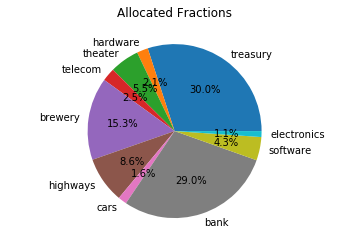

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()
                                                           
display_pie( list(all_fracs.values()), list(all_fracs),title='Allocated Fractions')

## What-if analysis: trying different values for target return

The above model was solved with a 'hard coded' value of 9% for the target. 
Now, one can wonder how variance would vary if we changed this target return value.

In this part, we will leverage DOcplex model edition capabilities to explore different scenarios with different target return values.
We will run the model for target return values betwen 4% and 20%. For each possible target return value,
we modify the right-hand side (or _rhs_) of the `ct_target` constraint we kept as a variable, and solve again,
keeping the values in a list.


In [32]:
target_returns = range(5,21)  # from 5 to 20, included
variances = []
for target in target_returns:
    # modify the constraint's right hand side.
    ct_return.rhs = target
    cur_s = mdl.solve()
    assert cur_s  # solve is OK
    cur_variance = variance.solution_value
    print('- for a target return of: {0}%, variance={1}'.format(target, cur_variance))
    variances.append(cur_variance)

- for a target return of: 5%, variance=0.28105252209449944
- for a target return of: 6%, variance=0.28105252214416476
- for a target return of: 7%, variance=0.28105252225011274
- for a target return of: 8%, variance=0.30818590869638357
- for a target return of: 9%, variance=0.40557734940356227
- for a target return of: 10%, variance=0.5503435250054378
- for a target return of: 11%, variance=0.7417945731282698
- for a target return of: 12%, variance=0.9798459646928664
- for a target return of: 13%, variance=1.2598935443762442
- for a target return of: 14%, variance=1.5813755540443808
- for a target return of: 15%, variance=1.9442235946080064
- for a target return of: 16%, variance=2.3469592331334908
- for a target return of: 17%, variance=2.7889850545628727
- for a target return of: 18%, variance=3.2707284094234224
- for a target return of: 19%, variance=3.792503995389222
- for a target return of: 20%, variance=4.3543118101284675


Again we use `matplotlib` to print variances vs. target returns.

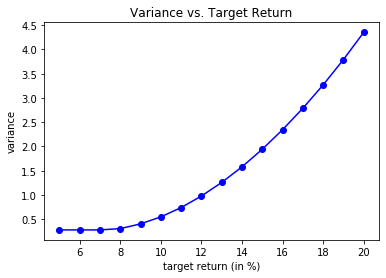

In [33]:
plt.plot(target_returns, variances, 'bo-')
plt.title('Variance vs. Target Return')
plt.xlabel('target return (in %)')
plt.ylabel('variance')
plt.show()

Not surprisingly, variance is increasing with target return.


# Summary

Having completed this notebook, you should be able to:

- Describe what a network model is, and the benefits of using network models

- Explain the concepts of nonlinearity and convexity

- Describe what a piecewise linear function is

- Describe the differences between:
  - Linear Programming (LP)
  - Integer Programming (IP)
  - Mixed-Integer Programming (MIP)
  - Quadratic Programming (QP)

- Construct a simple MIP model

## References
* [CPLEX Modeling for Python documentation](http://ibmdecisionoptimization.github.io/docplex-doc/)
* [IBM Decision Optimization](https://www.ibm.com/analytics/decision-optimization)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex).
* Contact us at dofeedback@wwpdl.vnet.ibm.com.